In [1]:
print("hello")
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns

hello


In [2]:
from nba_api.stats.endpoints import leaguegamefinder
gamefinder = leaguegamefinder.LeagueGameFinder(date_from_nullable='01/31/2020', league_id_nullable='00')
games = gamefinder.get_data_frames()[0]
print(games.head())

  SEASON_ID     TEAM_ID TEAM_ABBREVIATION             TEAM_NAME     GAME_ID  \
0     22024  1610612753               ORL         Orlando Magic  0022400470   
1     22024  1610612737               ATL         Atlanta Hawks  0022400477   
2     22024  1610612740               NOP  New Orleans Pelicans  0022400472   
3     22024  1610612765               DET       Detroit Pistons  0022400469   
4     22024  1610612759               SAS     San Antonio Spurs  0022400475   

    GAME_DATE      MATCHUP WL  MIN  PTS  ...  FT_PCT  OREB  DREB  REB  AST  \
0  2025-01-03    ORL @ TOR  W  240  106  ...   0.765    12    30   42   32   
1  2025-01-03    ATL @ LAL  L  240  102  ...   0.778    13    26   39   22   
2  2025-01-03  NOP vs. WAS  W  240  132  ...   0.818    13    24   37   36   
3  2025-01-03  DET vs. CHA  W  240   98  ...   0.615    14    37   51   21   
4  2025-01-03    SAS @ DEN  W  239  113  ...   0.615    14    42   56   31   

   STL  BLK  TOV  PF  PLUS_MINUS  
0   10    8   11  15 

In [3]:
games.columns

Index(['SEASON_ID', 'TEAM_ID', 'TEAM_ABBREVIATION', 'TEAM_NAME', 'GAME_ID',
       'GAME_DATE', 'MATCHUP', 'WL', 'MIN', 'PTS', 'FGM', 'FGA', 'FG_PCT',
       'FG3M', 'FG3A', 'FG3_PCT', 'FTM', 'FTA', 'FT_PCT', 'OREB', 'DREB',
       'REB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PLUS_MINUS'],
      dtype='object')

In [4]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (accuracy_score, confusion_matrix, precision_score, 
                             recall_score, f1_score, roc_curve, auc)
import matplotlib.pyplot as plt
from xgboost import XGBClassifier

In [5]:
games['Home'] = games['MATCHUP'].apply(lambda x: 1 if 'vs.' in x else 0)
games['AST-TOV Ratio'] = games['AST'] / (games['TOV'] + 1e-5)  # Avoid division by zero
games['eFG%'] = (games['FGM'] + 0.5 * games['FG3M']) / games['FGA']
games['TrueShooting%'] = games['PTS'] / (2 * (games['FGA'] + 0.44 * games['FTA']))


In [6]:
features = ['Home', 'eFG%', 'TrueShooting%', 'FG_PCT', 'FG3_PCT', 
            'FT_PCT', 'REB', 'AST', 'STL', 'BLK', 'AST-TOV Ratio']
target = 'WL'

In [7]:
features

['Home',
 'eFG%',
 'TrueShooting%',
 'FG_PCT',
 'FG3_PCT',
 'FT_PCT',
 'REB',
 'AST',
 'STL',
 'BLK',
 'AST-TOV Ratio']

In [8]:
target

'WL'

In [9]:
games['WL'].fillna('L', inplace=True)

C:\Users\swapn\AppData\Local\Temp\ipykernel_27080\1340455827.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  games['WL'].fillna('L', inplace=True)


In [10]:
X = games[features]
y = games[target]

In [11]:
y = y.map({'L': 0, 'W': 1})

In [12]:
X

,Home,eFG%,TrueShooting%,FG_PCT,FG3_PCT,FT_PCT,REB,AST,STL,BLK,AST-TOV Ratio
0,0,0.588608,0.612858,0.468,0.432,0.765,42,32,10,8,2.909088
1,0,0.440000,0.472572,0.410,0.176,0.778,39,22,10,3,2.749997
2,1,0.593750,0.624527,0.500,0.439,0.818,37,36,10,6,5.142850
3,1,0.483871,0.496353,0.419,0.324,0.615,51,21,13,7,1.615383
4,0,0.530303,0.539534,0.465,0.361,0.615,56,31,4,3,2.384614
...,...,...,...,...,...,...,...,...,...,...,...
12894,0,0.570588,0.584372,0.518,0.333,0.727,42,26,6,7,1.857142
12895,1,0.526042,0.549298,0.469,0.344,0.643,62,28,2,10,1.555555
12896,0,0.555556,0.593836,0.478,0.389,0.778,52,29,2,9,1.705881
12897,1,0.566327,0.599251,0.459,0.467,0.850,37,25,11,5,4.166660


In [13]:
y

0        1
1        0
2        1
3        1
4        1
        ..
12894    1
12895    0
12896    0
12897    1
12898    1
Name: WL, Length: 12899, dtype: int64

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [15]:
X_train

,Home,eFG%,TrueShooting%,FG_PCT,FG3_PCT,FT_PCT,REB,AST,STL,BLK,AST-TOV Ratio
1145,0,0.629032,0.635938,0.548,0.405,0.667,51,39,8,3,2.437498
3204,1,0.488889,0.540093,0.422,0.480,0.793,57,23,6,6,1.437499
9308,1,0.538835,0.559313,0.447,0.432,0.643,52,26,4,6,1.857142
8537,1,0.564516,0.603217,0.495,0.351,0.808,50,26,5,6,2.166665
11533,0,0.529070,0.530608,0.477,0.310,0.500,47,22,3,5,1.099999
...,...,...,...,...,...,...,...,...,...,...,...
11964,0,0.518750,0.557940,0.425,0.341,0.700,38,26,13,5,1.083333
5191,0,0.469388,0.488281,0.408,0.333,0.800,31,28,14,3,1.866665
5390,0,0.523256,0.537109,0.453,0.343,0.643,42,19,6,1,2.714282
860,1,0.560241,0.589818,0.470,0.429,0.677,36,27,8,5,1.421052


In [16]:
X_test

,Home,eFG%,TrueShooting%,FG_PCT,FG3_PCT,FT_PCT,REB,AST,STL,BLK,AST-TOV Ratio
1393,0,0.598765,0.640892,0.519,0.351,0.765,39,25,5,6,1.315789
7475,0,0.479381,0.514328,0.454,0.192,0.704,40,27,12,8,2.454543
8,1,0.420455,0.460978,0.364,0.278,1.000,37,9,6,4,0.818181
2848,1,0.439024,0.487701,0.366,0.300,0.714,34,20,4,1,2.499997
12126,0,0.449367,0.530017,0.418,0.238,0.811,38,21,2,3,2.333331
...,...,...,...,...,...,...,...,...,...,...,...
4802,0,0.451087,0.496656,0.391,0.314,0.818,44,23,12,3,3.285710
3495,1,0.550562,0.590194,0.483,0.333,0.826,46,23,6,1,1.916665
5168,1,0.500000,0.547481,0.444,0.303,0.767,56,25,12,9,1.315789
3822,0,0.561798,0.582563,0.472,0.372,0.667,45,28,9,5,1.555555


In [17]:
y_test

1393     1
7475     0
8        0
2848     0
12126    0
        ..
4802     0
3495     0
5168     1
3822     0
8085     0
Name: WL, Length: 2580, dtype: int64

In [18]:
y_train

1145     1
3204     1
9308     0
8537     0
11533    0
        ..
11964    0
5191     0
5390     0
860      0
7270     1
Name: WL, Length: 10319, dtype: int64

In [19]:
xgb_model = XGBClassifier(
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42,
    max_depth=3,              # Limit tree depth
    learning_rate=0.1,        # Lower learning rate
    n_estimators=100,         # Limit number of trees
    lambda_=1,                # L2 regularization
    alpha=0.5                 # L1 regularization
)

In [20]:
print(y.isnull().sum())

0


In [21]:
print(y.unique())

[1 0]


In [22]:
xgb_model.fit(X_train, y_train)

c:\Users\swapn\Desktop\NBA_2\env\Lib\site-packages\xgboost\core.py:158: UserWarning: [12:47:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "lambda_", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\swapn\Desktop\NBA_2\env\Lib\site-packages\sklearn\utils\_tags.py:354: FutureWarning: The XGBClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


AttributeError: 'super' object has no attribute '__sklearn_tags__'

AttributeError: 'super' object has no attribute '__sklearn_tags__'

XGBClassifier(alpha=0.5, base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None, lambda_=1,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=None, ...)

In [23]:
y_pred = xgb_model.predict(X_test)
y_proba = xgb_model.predict_proba(X_test)[:, 1]

In [24]:
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

In [25]:
print(f"Accuracy: {accuracy * 100:.2f}%")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-Score: {f1:.2f}")
print(f"Confusion Matrix:\n{conf_matrix}")

Accuracy: 83.33%
Precision: 0.83
Recall: 0.83
F1-Score: 0.83
Confusion Matrix:
[[1091  211]
 [ 219 1059]]


In [26]:
conf_matrix = confusion_matrix(y_test, y_pred)
print(f"Confusion Matrix:\n{conf_matrix}")

Confusion Matrix:
[[1091  211]
 [ 219 1059]]


In [27]:
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

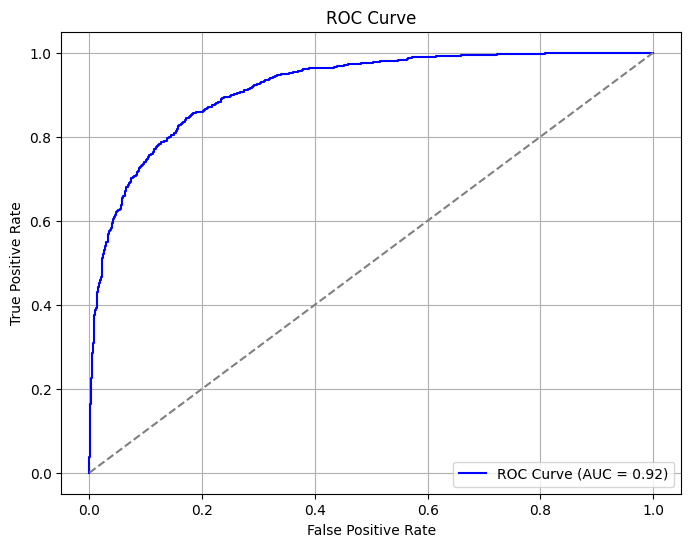

In [28]:
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonal line
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid()
plt.show()

In [29]:
# %% 
import pickle

# Save the model as a .pkl file
with open("xgb_classifier_model.pkl", "wb") as file:
    pickle.dump(xgb_model, file)
print("Model saved successfully in .pkl format!")


Model saved successfully in .pkl format!
